In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

# импортирую свои модули
import os
import sys
sys.path.append(os.path.abspath('..'))
from figures.plots import show_embeddings
from src.models import RepeatAutoencoder1, PositionalAutoencoder
from data.dataloading import TimeSeriesDataset, SequenceLengthSampler, pad_collate

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
spec_cols = ['supplier_status', 'volume_contracted', 'spec_price', 'delivery_period_lenght', ]
delivery_cols = ['price_change', 'lateness_percentage', 'weight_percentage']
time_cols = ['month', 'day', 'weekday']

data = pd.read_csv('../data/final_data/data.csv')
dataset = TimeSeriesDataset(data, spec_cols, delivery_cols, time_cols)

train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, lengths=[train_len, test_len])

bucket_boundaries = [2, 4, 6, 7, 10, 15, 20, 30, 40, 60, 80, 100]
lengths = [(i, len(item[1])) for i, item in enumerate(train_dataset)]
sampler = SequenceLengthSampler(lengths, bucket_boundaries, batch_size=16)

dataloader = DataLoader(train_dataset, collate_fn=pad_collate, batch_sampler=sampler)

In [60]:
model = RepeatAutoencoder1(3, 16, 3, 2)

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)

In [62]:
def validate(model, val_data):
    model.eval()
    loss_history = []
    for i, (h, x, t) in enumerate(val_data):
        h, x, t = h.unsqueeze(0), x.unsqueeze(0), t.unsqueeze(0)
        output = model(x)
        loss = criterion(output, x).item()
        loss_history.append(loss)
    return np.mean(loss_history)

In [63]:
train_history = []
val_history = []

for epoch in range(50):
    accumulated_loss = []
    for i, (h, x, t) in enumerate(dataloader):
        model.train()
        output = model(x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accumulated_loss.append(loss.item())
    
    train_loss = np.mean(accumulated_loss)
    val_loss = validate(model, test_dataset)
    
    # if val_loss < val_history[-1]:
    #     torch.save(model.state_dict(), '../src/weights/pa.pth')
    
    train_history.append(train_loss)
    val_history.append(val_loss)
    
    print(f'Train loss: {train_loss}, Val loss: {val_loss}, epoch: {epoch}')
    
    scheduler.step()

Train loss: 0.2635442203403834, Val loss: 0.21450676602921384, epoch: 0
Train loss: 0.18180001431199558, Val loss: 0.1679303472596024, epoch: 1
Train loss: 0.13470796510741553, Val loss: 0.13937092692247743, epoch: 2
Train loss: 0.10943605489207103, Val loss: 0.12657783103165623, epoch: 3
Train loss: 0.09474719628034269, Val loss: 0.12031400905967965, epoch: 4
Train loss: 0.0860303660909481, Val loss: 0.10906511388389512, epoch: 5
Train loss: 0.07826245172113619, Val loss: 0.10112606066370934, epoch: 6
Train loss: 0.0704732696279226, Val loss: 0.09649617050308734, epoch: 7
Train loss: 0.06591405071701635, Val loss: 0.09459981269040801, epoch: 8
Train loss: 0.060030110687127006, Val loss: 0.08699705603845667, epoch: 9
Train loss: 0.05409304175854606, Val loss: 0.08062892907908233, epoch: 10
Train loss: 0.049983912195517295, Val loss: 0.07517924925575155, epoch: 11
Train loss: 0.05077584438121823, Val loss: 0.07449689364394019, epoch: 12
Train loss: 0.04695746709373506, Val loss: 0.07193

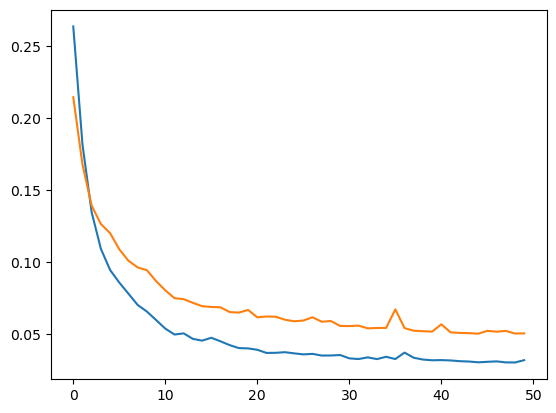

In [64]:
plt.plot(train_history)
plt.plot(val_history)

In [29]:
# torch.save(model.state_dict(), '../src/weights/pa.pth')

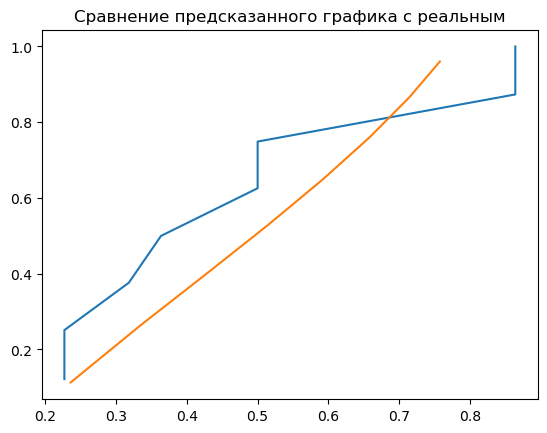

In [51]:
h, x, t = train_dataset[3]
h, x, t = h.unsqueeze(0), x.unsqueeze(0), t.unsqueeze(0)
output = model(x)


plt.title('Сравнение предсказанного графика с реальным')
i = 0
plt.plot(x[i, :, -2], x[i, :, -1])
plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

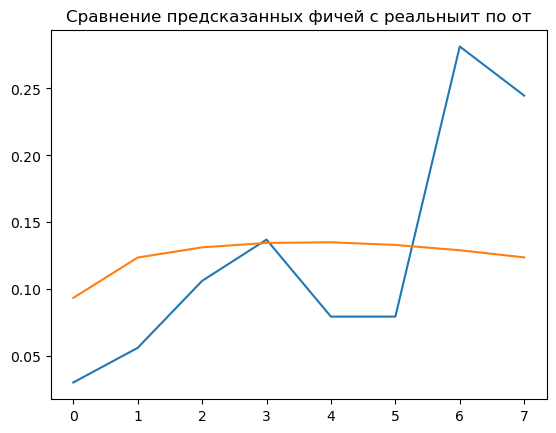

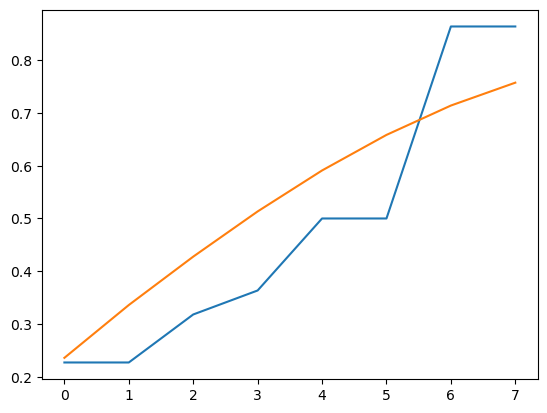

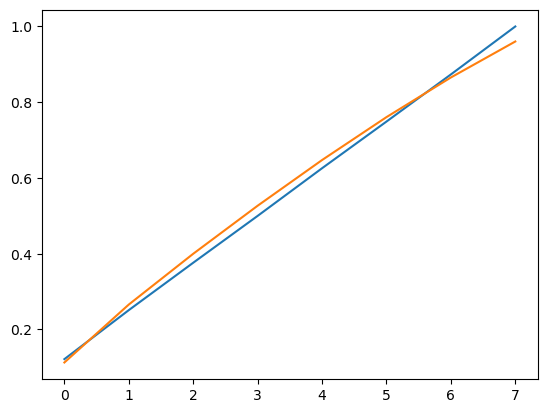

In [52]:
plt.title('Сравнение предсказанных фичей с реальныит по от')
i = 0
for feature in range(3):
    plt.plot(x[i, :, feature])
    plt.plot(output[i, :, feature].detach())
    plt.show()

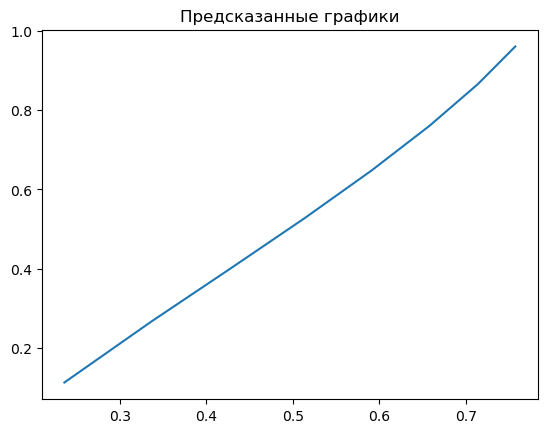

In [53]:
plt.title('Предсказанные графики')
for i in range(len(output)):
    plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

In [20]:
supplier_set = set(dataset.supplier[30:45])

indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [21]:
seqs = [dataset[i][1] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

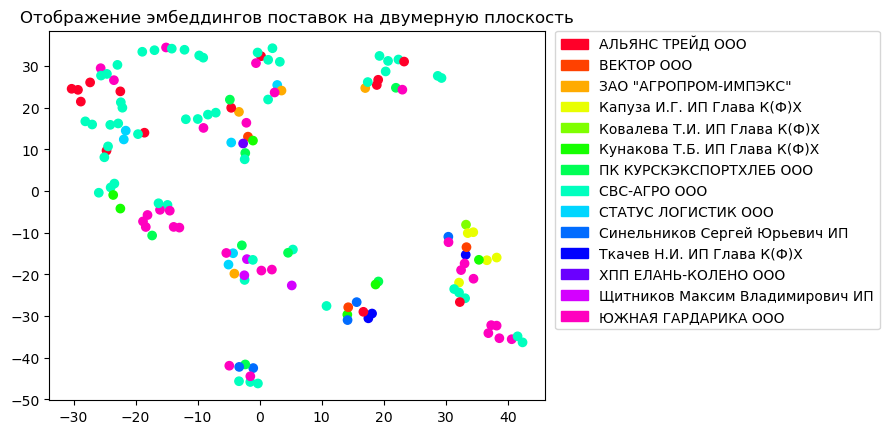

In [22]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
# plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [30]:
"""
Собираем датасет с эмбеддингами поставок
"""

embed_df = pd.DataFrame(columns = ['spec_id', 'supplier', 'date'] +
                        [f'{i}' for i in range(model.encoder.hidden_size)])
for i, (h, x, t) in tqdm(enumerate(dataset)):
    _, (embed, _) = model.encoder(x.unsqueeze(0))
    embed[-1, 0]
    
    embed = embed[-1, 0].detach().tolist()
    spec_data = [dataset.specs[i], dataset.supplier[i], dataset.specs_date[i]]
    
    embed_df.loc[len(embed_df)] = spec_data + embed

2840it [00:18, 155.72it/s]


In [31]:
embed_df.to_csv('../data/final_data/embed_df.csv', index=False)

In [3]:
# embed_df.head(2)